Test de classification pénalisée (ridge, lasso...)

In [13]:
import pandas as pd
import numpy as np
don =pd.read_csv("SAh.csv",header=0,sep=",")
don.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


In [14]:
import statsmodels.formula.api as smf
nomsvar = list(don.columns.difference(["chd"]))
formule = "chd~ 1 +" + "+".join(nomsvar)
print(formule)
reglog = smf.logit(formule,data=don).fit()
reglog.summary()

chd~ 1 +adiposity+age+alcohol+famhist+ldl+obesity+sbp+tobacco+typea
Optimization terminated successfully.
         Current function value: 0.510974
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            9
Date:                Wed, 09 Apr 2025   Pseudo R-squ.:                  0.2080
Time:                        11:44:41   Log-Likelihood:                -236.07
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 2.055e-22
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -6.1507      1.308     -4.701      0.000      -8.715      -3.587
famhist[T.Present]     0.9254      0.228      4.061      0.000       0.479       1.372
adiposity              0.0186      0.029      0.635      0.526      -0.039       0.076
age                    0.0452      0.012      3.728      0.000       0.021       0.069
alcohol                0.0001      0.004      0.027      0.978      -0.009       0.009
ldl                    0.1739      0.060      2.915      0.004       0.057       0.291
obesity               -0.0629      0.044     -1.422      0.155      -0.150       0.024
sbp                    0.0065      0.006      1.135      0.256      -0.005       0.018
tobacco                0.0794      0.027      2.984      0.003       0.027       0.132
typea                  0.0396      0.012      3.214      0.001       0.015       0.064
======================================================================================
"""

On essaye de faire de la régulariser (on verra plus tard plus tard comment gérer les variables qualit en attendant on enlève *famhist*)

In [15]:
don2 = don.drop(columns=["famhist"])
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

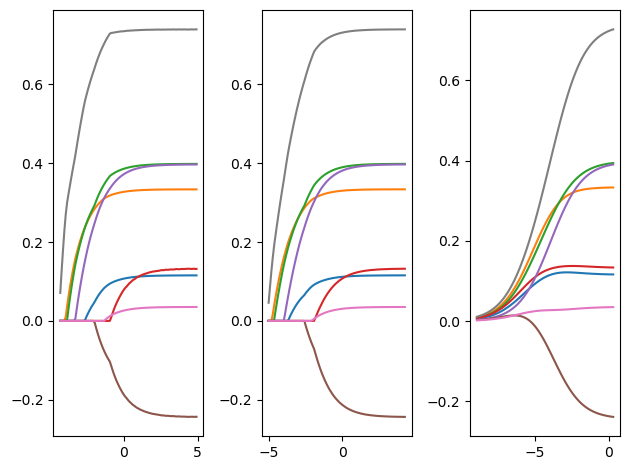

In [25]:
X = don2.drop(columns=["chd"]).to_numpy()
Y = don2["chd"].to_numpy()
scalerX = StandardScaler().fit(X)
Xcr= scalerX.transform(X)
l0 = np.abs(Xcr.transpose().dot((Y  - Y.mean()))).max()/X.shape[0]
llc = np.linspace(0,-4,100)
ll = l0*10**llc
Cs_lasso = 1/ 0.9/ X.shape[0] / (l0*10**(llc))
Cs_ridge = 1/ 0.9/ X.shape[0] / ((l0*10**(llc)) * 100)
Cs_enet =  1/ 0.9/ X.shape[0] / ((l0*10**(llc)) / 0.5)

coefs_lasso = []
coefs_enet = []
coefs_ridge = []

Xcr = StandardScaler().fit(X).transform(X)
for a, b, c in zip(Cs_lasso, Cs_ridge, Cs_enet) :
    ## lasso
    lasso = LogisticRegression(penalty="l1", C=a, solver="liblinear", warm_start=True).fit(Xcr, Y)
    coefs_lasso.append(lasso.coef_[0])
    ## ridge
    ridge = LogisticRegression(penalty="l2", C=b, warm_start=True).fit(Xcr, Y)
    coefs_ridge.append(ridge.coef_[0])
    ## enet
    enet = LogisticRegression(penalty="elasticnet", C=c, solver="saga", l1_ratio=0.5, warm_start=True).fit(Xcr, Y)
    coefs_enet.append(enet.coef_[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.log(Cs_lasso), coefs_lasso)
ax2.plot(np.log(Cs_enet), coefs_enet)
ax3.plot(np.log(Cs_ridge), coefs_ridge)
fig.tight_layout()

Cool on a compris donc on peut choisir $\lambda$ de façon optimale (cela veur dire par VC)

In [22]:
clf = LogisticRegressionCV(cv=5, penalty='l1',random_state=0,solver='liblinear').fit(X, Y)
clf.C_

array([2.7825594])

Compréhension de la foret dans le cadre de la classif

In [ ]:
from sklearn.ensemble import RandomForestClassifier
foret = RandomForestClassifier(n_estimators=200).fit(X,Y)
prev = pd.DataFrame(foret.predict(X))
prev.head()
prev = pd.DataFrame(foret.predict_proba(X))
print(prev.head())

          0         1
0 -1.931022 -0.156654
1 -1.203973 -0.356675
2 -0.040822 -3.218876
3 -2.079442 -0.133531
4 -1.406497 -0.281038
       0      1
0  0.145  0.855
1  0.300  0.700
2  0.960  0.040
3  0.125  0.875
4  0.245  0.755


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:910: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


COMPRENDRE LE CODAGE

In [11]:
import pandas as pd
don = pd.read_csv("ozonecomplet.csv",header=0,sep=";")
don = don.drop(columns=['nomligne'])
don = don.rename(columns={'O3':'Y'})
doncod = pd.get_dummies(don, columns=['Ne','Dv'])
doncod.head()
import statsmodels.formula.api as smf
nomsvar = list(don.columns.difference(["Y"]))
formule = "Y~ 1 +" + "+".join(nomsvar)
nomsvarcod = list(doncod.columns.difference(["Y"]))
formulecod = "Y~ 1 +" + "+".join(nomsvarcod)

In [12]:

reg = smf.ols(formule,data=don).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     23.01
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           8.74e-25
Time:                        15:55:57   Log-Likelihood:                -450.42
No. Observations:                 112   AIC:                             930.8
Df Residuals:                      97   BIC:                             971.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2654     15.944      1.020      0.310     -15.379      47.910
Dv[T.N]        0.5396      6.695      0.081      0.936     -12.747      13.826
Dv[T.O]        5.5363      8.248      0.671      0.504     -10.834      21.906
Dv[T.S]        5.4203      7.162      0.757      0.451      -8.794      19.634
Ne[T.s]        3.2471      3.483      0.932      0.353      -3.665      10.159
Ne12          -0.6056      1.426     -0.425      0.672      -3.436       2.225
Ne15          -0.0172      1.036     -0.017      0.987      -2.073       2.039
Ne9           -2.1098      0.960     -2.198      0.030      -4.015      -0.205
O3v            0.3444      0.067      5.141      0.000       0.211       0.477
T12            1.9726      1.476      1.337      0.184      -0.956       4.901
T15            0.4503      1.187      0.379      0.705      -1.906       2.806
T9             0.0392      1.165      0.034      0.973      -2.273       2.351
Vx12           0.5138      1.247      0.412      0.681      -1.961       2.989
Vx15           0.7266      0.952      0.763      0.447      -1.163       2.616
Vx9            0.4826      0.988      0.489      0.626      -1.478       2.443
==============================================================================
Omnibus:                        7.458   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               13.894
Skew:                           0.084   Prob(JB):                     0.000962
Kurtosis:                       4.717   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:

regcod = smf.ols(formulecod,data=doncod).fit()
regcod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     23.01
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           8.74e-25
Time:                        15:56:21   Log-Likelihood:                -450.42
No. Observations:                 112   AIC:                             930.8
Df Residuals:                      97   BIC:                             971.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.8645      8.835      1.343      0.182      -5.671      29.400
Dv_E[T.True]     0.0921      5.489      0.017      0.987     -10.802      10.987
Dv_N[T.True]     0.6317      2.797      0.226      0.822      -4.920       6.183
Dv_O[T.True]     5.6284      4.610      1.221      0.225      -3.522      14.779
Dv_S[T.True]     5.5124      4.245      1.298      0.197      -2.913      13.938
Ne_n[T.True]     4.3087      4.569      0.943      0.348      -4.759      13.377
Ne_s[T.True]     7.5558      4.922      1.535      0.128      -2.212      17.324
Ne12            -0.6056      1.426     -0.425      0.672      -3.436       2.225
Ne15            -0.0172      1.036     -0.017      0.987      -2.073       2.039
Ne9             -2.1098      0.960     -2.198      0.030      -4.015      -0.205
O3v              0.3444      0.067      5.141      0.000       0.211       0.477
T12              1.9726      1.476      1.337      0.184      -0.956       4.901
T15              0.4503      1.187      0.379      0.705      -1.906       2.806
T9               0.0392      1.165      0.034      0.973      -2.273       2.351
Vx12             0.5138      1.247      0.412      0.681      -1.961       2.989
Vx15             0.7266      0.952      0.763      0.447      -1.163       2.616
Vx9              0.4826      0.988      0.489      0.626      -1.478       2.443
==============================================================================
Omnibus:                        7.458   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               13.894
Skew:                           0.084   Prob(JB):                     0.000962
Kurtosis:                       4.717   Cond. No.                     2.82e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.45e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Je pense qu'il faut prendre l'habitude d'utiliser dmatrix ?

In [15]:
from patsy import dmatrix
nomsvar = list(don.columns.difference(["Y"]))
formule = "~" + "+".join(nomsvar)
X = dmatrix(formule, don, return_type="dataframe").iloc[:,1:].to_numpy()
print(X)

[[ 1.      0.      0.     ... -1.7101 -0.6946  0.6946]
 [ 1.      0.      0.     ... -4.     -3.     -4.3301]
 [ 0.      0.      0.     ...  1.8794  0.5209  2.9544]
 ...
 [ 0.      0.      1.     ...  0.8682  0.8682  1.5   ]
 [ 0.      1.      0.     ... -3.7588 -4.     -4.    ]
 [ 0.      0.      1.     ... -1.0419 -4.      0.    ]]
